# Pre

In [26]:
from __future__ import annotations
%pip install geopy
%pip install --upgrade --force-reinstall \
    mediocreatbest@git+https://gist.github.com/player1537/3457b026ed6ef6696d758517f55a58df.git
try:
    from mediocreatbest import auto
except ImportError:
    %pip install --quiet --upgrade pip
    %pip install --upgrade --force-reinstall \
        mediocreatbest@git+https://gist.github.com/player1537/3457b026ed6ef6696d758517f55a58df.git
    from mediocreatbest import auto

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
  Cloning https://gist.github.com/player1537/3457b026ed6ef6696d758517f55a58df.git to /tmp/pip-install-34n3ruj5/mediocreatbest_c5b7d58950db495aae6cfa8a6b2e4925
  Running command git clone --filter=blob:none --quiet https://gist.github.com/player1537/3457b026ed6ef6696d758517f55a58df.git /tmp/pip-install-34n3ruj5/mediocreatbest_c5b7d58950db495aae6cfa8a6b2e4925
  Resolved https://gist.github.com/player1537/3457b026ed6ef6696d758517f55a58df.git to commit e41d8d653f5889dd403fed60135cfcf0de585704
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for mediocreatbest: fi

# Config

In [27]:
config = auto.types.SimpleNamespace()

/auto.pprint.pp config width=144

namespace()


# Lib

## State name to abbreviation (monkey brain way)

In [28]:
def state_abbreviation(state_name):
    state_abbreviations = {
        'alabama': 'AL', 'alaska': 'AK', 'arizona': 'AZ', 'arkansas': 'AR',
        'california': 'CA', 'colorado': 'CO', 'connecticut': 'CT', 'delaware': 'DE',
        'florida': 'FL', 'georgia': 'GA', 'hawaii': 'HI', 'idaho': 'ID',
        'illinois': 'IL', 'indiana': 'IN', 'iowa': 'IA', 'kansas': 'KS',
        'kentucky': 'KY', 'louisiana': 'LA', 'maine': 'ME', 'maryland': 'MD',
        'massachusetts': 'MA', 'michigan': 'MI', 'minnesota': 'MN', 'mississippi': 'MS',
        'missouri': 'MO', 'montana': 'MT', 'nebraska': 'NE', 'nevada': 'NV',
        'new hampshire': 'NH', 'new jersey': 'NJ', 'new mexico': 'NM',
        'new york': 'NY', 'north carolina': 'NC', 'north dakota': 'ND',
        'ohio': 'OH', 'oklahoma': 'OK', 'oregon': 'OR', 'pennsylvania': 'PA',
        'rhode island': 'RI', 'south carolina': 'SC', 'south dakota': 'SD',
        'tennessee': 'TN', 'texas': 'TX', 'utah': 'UT', 'vermont': 'VT',
        'virginia': 'VA', 'washington': 'WA', 'west virginia': 'WV',
        'wisconsin': 'WI', 'wyoming': 'WY'
    }
    
    return state_abbreviations.get(state_name.lower().strip(), None)

## Polygon Containment

In [1]:
def is_point_in_polygon(point, polygon):
    x, y = point
    inside = False
    
    # Get the number of vertices in the polygon
    n = len(polygon)
    
    # Store the first and last point of the polygon
    p1x, p1y = polygon[0]
    
    # Iterate through each edge of the polygon
    for i in range(n + 1):
        # Get the next point (wrapping around to the first point when needed)
        p2x, p2y = polygon[i % n]
        
        # Check if the point is within the vertical range of the edge
        if y > min(p1y, p2y):
            if y <= max(p1y, p2y):
                # If the point is within the horizontal range, calculate the x-intercept
                if x <= max(p1x, p2x):
                    # Calculate the x-intercept of the ray
                    if p1y != p2y:
                        xinters = (y - p1y) * (p2x - p1x) / (p2y - p1y) + p1x
                    
                    # If the point is on the right side of the x-intercept, toggle inside
                    if p1x == p2x or x <= xinters:
                        inside = not inside
        
        # Move to the next edge
        p1x, p1y = p2x, p2y
    
    return inside


## Address

In [30]:
from opencage.geocoder import OpenCageGeocode
def dms_to_decimal(dms_str):
    # Regular expression to parse the DMS format
    match = auto.re.match(r"(\d+)° (\d+)' ([\d.]+)'' ([NSEW])", dms_str)
    if not match:
        raise ValueError("Invalid DMS format")

    degrees = int(match.group(1))
    minutes = int(match.group(2))
    seconds = float(match.group(3))
    direction = match.group(4)

    # Convert to decimal degrees
    decimal_degrees = degrees + minutes / 60 + seconds / 3600

    # Adjust sign for South and West
    if direction in 'SW':
        decimal_degrees *= -1

    return decimal_degrees

def addr_to_coords(addr: str) -> (float, float):
    API_KEY = '6cda2bcd35394349886014d2a5c6f497'
    geocoder = auto.opencage.geocoder.OpenCageGeocode(API_KEY)

    data = geocoder.geocode(addr)[0]
    lat = data['annotations']['DMS']['lat']
    lng = data['annotations']['DMS']['lng']
    lat = dms_to_decimal(lat)
    lng = dms_to_decimal(lng)
    return (lat, lng)

def addr_to_state(addr: str) -> str:
    API_KEY = '6cda2bcd35394349886014d2a5c6f497'
    geocoder = auto.opencage.geocoder.OpenCageGeocode(API_KEY)

    data = geocoder.geocode(addr)[0]
    state = data['components']
    return state_abbreviation(state.get('state'))

def scope():
    print(addr_to_coords('8000 Middlebrook Pike Knoxville TN'))
    print(addr_to_state('8000 Middlebrook Pike Knoxville TN'))

/scope

(35.943011, -84.05265299999999)
TN


## Lat/lng from point with radius & direction

In [31]:
def get_point_at_distance(lat, lon, distance_miles, bearing_degrees):
    """
    Calculate a new coordinate point given:
    - Starting point (latitude, longitude)
    - Distance in miles
    - Bearing in degrees (0° is North, 90° is East, etc.)
    
    Returns: (new_latitude, new_longitude)
    """
    # Convert to radians
    lat_rad = auto.math.radians(lat)
    lon_rad = auto.math.radians(lon)
    bearing_rad = auto.math.radians(bearing_degrees)
    
    # Earth's radius in miles
    R = 3959
    
    # Calculate angular distance
    d = distance_miles / R
    
    # Calculate new latitude
    new_lat_rad = auto.math.asin(
        auto.math.sin(lat_rad) * auto.math.cos(d) +
        auto.math.cos(lat_rad) * auto.math.sin(d) * auto.math.cos(bearing_rad)
    )
    
    # Calculate new longitude
    new_lon_rad = lon_rad + auto.math.atan2(
        auto.math.sin(bearing_rad) * auto.math.sin(d) * auto.math.cos(lat_rad),
        auto.math.cos(d) - auto.math.sin(lat_rad) * auto.math.sin(new_lat_rad)
    )
    
    # Convert back to degrees
    new_lat = auto.math.degrees(new_lat_rad)
    new_lon = auto.math.degrees(new_lon_rad)
    
    return (new_lat, new_lon)

def scope():
    lat, lng = addr_to_coords('8000 Middlebrook Pike Knoxville TN')
    newpoint_north = get_point_at_distance(lat, lng, 1.0, 0.0)
    print((lat, lng))
    print(newpoint_north)

/scope

(35.943011, -84.05265299999999)
(35.957483285807804, -84.05265299999999)


# Census

In [32]:
from __future__ import annotations
%pip install shapely
try:
    from mediocreatbest import auto
except ImportError:
    %pip install --quiet --upgrade pip
    %pip install --upgrade --force-reinstall \
        mediocreatbest==0.3.1
        # --index-url https://test.pypi.org/simple/
    from mediocreatbest import auto

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Lib

In [33]:
%%module vainl
from __future__ import annotations
from mediocreatbest import auto

VAINL_API_URL = 'https://sdoh.with.vainl.in.production.is.mediocreatbest.xyz/vainl/'  #@param ["https://sdoh.with.vainl.in.development.is.mediocreatbest.xyz/vainl/", "https://sdoh.with.vainl.in.staging.is.mediocreatbest.xyz/vainl/", "https://sdoh.with.vainl.in.production.is.mediocreatbest.xyz/vainl/"]

@auto.functools.cache
def VAINL_API_KEY():
    return "73AKs9kFwwIEoWsFndCBT1OVtFe"
    # return auto.google.colab.userdata.get('VAINL_API_KEY')


def Identity(x: auto.typing.Any, /) -> str:
    if hasattr(x, 'identity'):
        x = x.identity
    elif isinstance(x, str):
        pass
    elif 'identity' in x:
        x = x['identity']
    else:
        raise ValueError(f'cannot identity {x!r}')
    return x


def Ideation(
    ideation: str,
    /,
    api_url: str | auto.typing.Literal[...] = ...,
    api_key: str | auto.typing.Literal[...] | None = ...,
    cache: dict | auto.typing.Literal[...] | None = (
        None  # no cache
        # ...  # in-memory cache
    ),
):
    if api_url is Ellipsis:
        api_url = VAINL_API_URL
    if api_key is Ellipsis:
        api_key = VAINL_API_KEY()
    if cache is Ellipsis:
        global __796c44a7
        try: __796c44a7
        except NameError: __796c44a7 = {}
        cache = __796c44a7

    ideation = Identity(ideation)

    url = api_url
    url = f'{url}linen_den/'
    url = f'{url}ideation/{auto.urllib.parse.quote(ideation)}/'

    headers = {}
    headers['Accept'] = 'application/json'
    if api_key is not None:
        headers['Authorization'] = f'Bearer {api_key}'

    ckey = url
    if cache is None or ckey not in cache:
        print(url)
        with auto.requests.request(
            'GET',
            url,
            headers=headers,
        ) as response:
            response.raise_for_status()
            json = response.json()

        if cache is not None:
            cache[ckey] = json

    else:
        json = cache[ckey]

    def Ideation(json):
        json = json.copy()
        identity = json.pop('identity')
        location = json.pop('location')
        material = json.pop('material')
        # magazines_ = json.pop('magazines')
        properties_ = json.pop('properties')
        catalysts_ = json.pop('catalysts')
        assert not json, list(json)

        material = Material(material)

        # magazines = []
        # for magazine in magazines_:
        #     magazine = Magazine(magazine)
        #     magazines.append(magazine)

        properties = []
        for property in properties_:
            property = Property(property)
            properties.append(property)

        catalysts = []
        for catalyst in catalysts_:
            catalyst = Catalyst(catalyst)
            catalysts.append(catalyst)

        return auto.types.SimpleNamespace(
            identity=identity,
            location=location,
            ideation=ideation,
            material=material,
            # magazines=magazines,
            properties=properties,
            catalysts=catalysts,
        )

    def Material(json):
        json = json.copy()
        location = json.pop('location')
        assert not json, list(json)

        return auto.types.SimpleNamespace(
            location=location,
        )

    def Magazine(json):
        json = json.copy()
        identity = json.pop('identity')
        location = json.pop('location')
        assert not json, list(json)

        return auto.types.SimpleNamespace(
            identity=identity,
            location=location,
        )

    def Property(json):
        json = json.copy()
        identity = json.pop('identity')
        fullname = json.pop('fullname')
        delegates = json.pop('delegates')
        metadata = json.pop('metadata')
        assert not json, list(json)

        return auto.types.SimpleNamespace(
            identity=identity,
            fullname=fullname,
            delegates=delegates,
            metadata=metadata,
        )

    def Catalyst(json):
        json = json.copy()
        identity = json.pop('identity')
        assert not json, list(json)

        return auto.types.SimpleNamespace(
            identity=identity,
        )

    json = json.copy()
    ideation = json.pop('ideation')
    assert not json, list(json)

    ideation = Ideation(ideation)

    return ideation


def Property(
    property: str,
    *,
    ideation: str,
    api_url: str | auto.typing.Literal[...] = ...,
    api_key: str | auto.typing.Literal[...] = ...,
    cache: dict | auto.typing.Literal[...] | None = (
        None  # disable caching
        # ...  # in-memory caching
    ),
):
    if api_url is ...:
        api_url = VAINL_API_URL
    if api_key is ...:
        api_key = VAINL_API_KEY()
    if cache is ...:
        global __c7752b54
        try: __c7752b54
        except NameError: __c7752b54 = {}
        cache = __c7752b54

    ideation = Identity(ideation)
    property = Identity(property)

    if ':' in property:
        property, _ = property.split(':', 1)

    url = api_url
    url = f'{url}linen_den/'
    url = f'{url}ideation/{auto.urllib.parse.quote(ideation)}/'
    url = f'{url}property/{auto.urllib.parse.quote(property)}/'

    ckey = url
    if cache is None or ckey not in cache:
        with auto.requests.request(
            'GET',
            url,
            headers={
                'Accept': 'application/json',
                'Authorization': f'Bearer {api_key}',
            },
        ) as response:
            response.raise_for_status()
            json = response.json()

        if cache is not None:
            cache[ckey] = json

    else:
        json = cache[ckey]

    def Property(json):
        json = json.copy()
        ideation = json.pop('ideation')
        identity = json.pop('identity')
        delegates = json.pop('delegates')
        metadata = json.pop('metadata')
        assert not json, list(json)

        ideation = Ideation(ideation)

        return auto.types.SimpleNamespace(
            identity=identity,
            delegates=delegates,
            metadata=metadata,
        )

    def Ideation(json):
        json = json.copy()
        identity = json.pop('identity')
        location = json.pop('location')
        assert not json, list(json)

        return auto.types.SimpleNamespace(
            identity=identity,
            location=location,
        )

    json = json.copy()
    property = json.pop('property')
    assert not json, list(json)

    property = Property(property)

    return property


def Material(
    properties: list[str],
    *,
    ideation: str,

    baseline: str | list[str] | None = None,
    neighbors: int | None = None,
    varietal: str | None = 'distance',

    verbose: bool | int = False,

    api_url: str | auto.typing.Literal[...] = ...,
    api_key: str | auto.typing.Literal[...] | None = ...,
    cache: dict | auto.typing.Literal[...] | None = (
        None  # no cache
        # ...  # in-memory cache
    ),
):
    if api_url is Ellipsis:
        api_url = VAINL_API_URL
    if api_key is Ellipsis:
        api_key = VAINL_API_KEY()
    if cache is Ellipsis:
        global __62d2c2d6
        try: __62d2c2d6
        except NameError: __62d2c2d6 = auto.shelve.open('vainl.Material.cache')
        cache = __62d2c2d6
    verbose = int(verbose)

    if baseline is not None:
        if isinstance(baseline, str):
            baseline = [baseline]

    ideation = Identity(ideation)

    it = properties
    properties = []
    for property in it:
        property = Identity(property)
        properties.append(property)

    ckey = {
        'properties': properties,
        'baseline': baseline,
        'neighbors': neighbors,
        'varietal': varietal,
        'ideation': ideation,
    }
    ckey = auto.json.dumps(ckey, sort_keys=True)
    if cache is None or ckey not in cache:
        it = properties
        it = auto.more_itertools.chunked(it, 4)
        if verbose >= 1:
            it = auto.tqdm.auto.tqdm(it)

        dfs = []
        for properties in it:
            query = []
            if baseline is not None:
                for baseline in baseline:
                    query.append(('b', baseline))

                query.append(('k', neighbors))
                query.append(('varietal', varietal))

            for property in properties:
                query.append(('property', property))

            url = api_url
            url = f'{url}linen_den/'
            url = f'{url}ideation/{auto.urllib.parse.quote(ideation)}/'
            url = f'{url}material/'
            url = f'{url}?{auto.urllib.parse.urlencode(query)}'

            headers = {}
            headers['Accept'] = 'text/csv'
            if api_key is not None:
                headers['Authorization'] = f'Bearer {api_key}'

            # ckey = {
            #     'url': url,
            #     'headers': headers,
            # }
            # ckey = auto.json.dumps(ckey, sort_keys=True)
            # if cache is None or ckey not in cache:
            print(url)
            df = auto.pd.read_csv(
                url,
                dtype={
                    'where': str,
                },
                quoting=auto.csv.QUOTE_NONNUMERIC,
                low_memory=False,
                storage_options={
                    **headers,
                },
            ).set_index('where')

            if 'geometry' in df.columns:
                geometry = df['geometry']
                import shapely.wkt
                geometry = geometry.apply(lambda s: (
                    auto.shapely.wkt.loads(s)
                ) if not auto.pd.isna(s) else (
                    None
                ))
                df = df.assign(**{
                    'geometry': geometry,
                })
                df = auto.geopandas.GeoDataFrame(df, geometry='geometry')

            dfs.append(df)

        df = auto.pd.concat(dfs, axis=1)

        if cache is not None:
            cache[ckey] = df

    else:
        df = cache[ckey]

    return df


def Bincount(
    *,
    ideation: str,

    xproperty: str,

    baseline: str | list[str] | None = None,
    neighbors: int | None = None,
    varietal: str | None = 'distance',

    width: int | str = 600,
    height: int | str = 400,

    api_url: str | auto.typing.Literal[...] = ...,
    api_key: str | auto.typing.Literal[...] = ...,
    cache: dict | auto.typing.Literal[...] | None = (
        None  # no cache
        # ...  # in-memory cache
    ),
):
    if api_url is ...:
        api_url = VAINL_API_URL
    if api_key is ...:
        api_key = VAINL_API_KEY()
    if cache is ...:
        global __2722ed6a
        try: __2722ed6a
        except NameError: __2722ed6a = {}
        cache = __2722ed6a

    ideation = Identity(ideation)
    xproperty = Identity(xproperty)

    query = []
    query.append(('x', xproperty))
    if baseline is not None:
        if isinstance(baseline, str):
            baseline = [baseline]

        for baseline in baseline:
            query.append(('b', baseline))

        query.append(('k', neighbors))
        query.append(('v', varietal))
    query.append(('w', width))
    query.append(('h', height))

    url = f'{url}linen_den/'
    url = f'{url}ideation/{auto.urllib.parse.quote(ideation)}/'
    url = f'{url}bincount/'
    url = f'{url}?{auto.urllib.parse.urlencode(query)}'

    ckey = url
    if cache is None or ckey not in cache:
        with auto.requests.request(
            'GET',
            url,
            headers={
                'Accept': 'vega',
                'Authorization': f'Bearer {api_key}',
            },
        ) as response:
            response.raise_for_status()
            json = response.json()

        if cache is not None:
            cache[ckey] = json

    else:
        json = cache[ckey]

    return json


def Dotchart(
    *,
    ideation: str,

    xproperty: str,
    yproperty: str,

    baseline: str | None | list[str] = None,
    neighbors: int | None = None,
    varietal: str | None = 'distance',

    width: int | str = 600,
    height: int | str = 400,

    api_url: str | auto.typing.Literal[...] = ...,
    api_key: str | auto.typing.Literal[...] = ...,
    cache: dict | auto.typing.Literal[...] | None = (
        None  # no cache
        # ...  # in-memory cache
    )
):
    if api_url is ...:
        api_url = VAINL_API_URL
    if api_key is ...:
        api_key = VAINL_API_KEY()
    if cache is ...:
        global __3879fd46
        try: __3879fd46
        except NameError: __3879fd46 = {}
        cache = __3879fd46

    ideation = Identity(ideation)
    xproperty = Identity(xproperty)
    yproperty = Identity(yproperty)

    query = []
    query.append(('xproperty', xproperty))
    query.append(('yproperty', yproperty))
    if baseline is not None:
        if isinstance(baseline, str):
            baseline = [baseline]

        for baseline in baseline:
            query.append(('baseline', baseline))

        query.append(('neighbor', neighbors))
        query.append(('varietal', varietal))
    query.append(('width', width))
    query.append(('height', height))

    url = f'{url}linen_den/'
    url = f'{url}ideation/{auto.urllib.parse.quote(ideation)}/'
    url = f'{url}dotchart/'
    url = f'{url}?{auto.urllib.parse.urlencode(query)}'

    ckey = url
    if cache is None or ckey not in cache:
        with auto.requests.request(
            'GET',
            url,
            headers={
                'Accept': 'vega',
                'Authorization': f'Bearer {api_key}',
            },
        ) as response:
            response.raise_for_status()
            json = response.json()

        if cache is not None:
            cache[ckey] = json

    else:
        json = cache[ckey]

    return json



def scope():
    ideation = Ideation(
        'By Census Tract',
        cache=None,
    )
    print(auto.pprint.pformat(ideation, indent=2)[:10000])

    dotchart = Dotchart(
        ideation=ideation,
        xproperty='P0F38078',
        yproperty='P017296A',
    )
    print(auto.pprint.pformat(dotchart, indent=2)[:4000])

# /scope


<module 'vainl'>

In [34]:
#@title Ideation
@auto.functools.cache
def Ideation():
    ideation = auto.vainl.Ideation(
        # 'By Address'
        'By Census Tract',
    )

    return ideation


def scope():
    ideation = Ideation()

    with auto.mediocreatbest.Textarea():
        auto.pprint.pp(ideation.properties[0], width=112)

    with auto.mediocreatbest.Textarea():
        for property in ideation.properties:
            print(auto.json.dumps(f'{property.identity}: {property.delegates["Axis Label"]}'))
            print(auto.textwrap.fill(
                str(property.delegates["Embedding Passage"]),
                initial_indent='    ',
                subsequent_indent='    ',
                width=72,
            ))
            print()

/scope


https://sdoh.with.vainl.in.production.is.mediocreatbest.xyz/vainl/linen_den/ideation/By%20Census%20Tract/


In [35]:
#@title Property

def _Property(
    identity: str,
    *,
    ideation,
):
    ideation = auto.vainl.Ideation(ideation)
    property = auto.vainl.Property(
        identity,
        ideation=ideation,
    )

    return property


@auto.functools.cache
def Property(identity: str):
    ideation = Ideation()

    property = _Property(
        identity,
        ideation=ideation,
    )

    return property


def scope():
    property = Property('P0F38078: Adults Who Sleep Less Than 7 Hours')

    with auto.mediocreatbest.Textarea():
        /auto.pprint.pprint property

/scope


https://sdoh.with.vainl.in.production.is.mediocreatbest.xyz/vainl/linen_den/ideation/By%20Census%20Tract/


In [36]:
#@title Material

def _Material(
    *,
    ideation,
    properties: list[str],
) -> auto.pd.DataFrame:
    ideation = auto.vainl.Ideation(ideation)

    it = properties
    properties = []
    for property in it:
        property = auto.vainl.Property(
            property,
            ideation=ideation,
        )

        properties.append(property)

    material = auto.vainl.Material(
        properties,
        ideation=ideation,
    )

    return material


@auto.functools.cache
def Material() -> auto.pd.DataFrame:
    ideation = Ideation()

    material = _Material(
        ideation=ideation,
        properties=[
            'geometry',
            'P0F38078: Adults Who Sleep Less Than 7 Hours',
            # 'P017296A: Adults Who Had a Dental Visit in the Last Year',
        ],
    )

    return material

material = Material()
/display material



https://sdoh.with.vainl.in.production.is.mediocreatbest.xyz/vainl/linen_den/ideation/By%20Census%20Tract/
https://sdoh.with.vainl.in.production.is.mediocreatbest.xyz/vainl/linen_den/ideation/By%20Census%20Tract/material/?property=geometry&property=P0F38078


geometry  P0F38078
where                                                                   
01005950300  POLYGON ((-85.4363 31.78899, -85.4421 31.79416...      43.6
01005950900  POLYGON ((-85.1972 31.83849, -85.18865 31.8398...      43.9
01005950800  POLYGON ((-85.14077 31.89143, -85.13948 31.894...      38.7
01005950700  POLYGON ((-85.14577 31.89008, -85.14577 31.892...      41.5
01005950600  POLYGON ((-85.14577 31.89008, -85.15077 31.888...      42.7
...                                                        ...       ...
36065024900                                               None      33.9
46102940500                                               None      34.2
46102940800                                               None      35.3
46102940900                                               None      34.8
51019050100                                               None      36.5

[73045 rows x 2 columns]

In [37]:
def scope(pfn: str):
    # material = Material()

    # /display material
    # print(material['geometry'][0])
    # print(material[pfn][0])
    
    material_geo = []
    material_values = []
    index = 0
    it = auto.tqdm.auto.tqdm(material.iterrows())
    for i, row in it:
        geoms = row.geometry
        if isinstance(geoms, auto.shapely.MultiPolygon):
            for poly in geoms.geoms:
                material_geo.append(poly)
                material_values.append(row[pfn])
                
        elif isinstance(geoms, auto.shapely.Polygon):
            material_geo.append(geoms)
            material_values.append(row[pfn])
           
        else:
            pass

        index += 1
    
    return material_geo, material_values

    
    /display material

material_geo, material_values = scope(pfn='P0F38078')
# /display material_data


0it [00:00, ?it/s]

## Config

In [38]:
config.app = auto.types.SimpleNamespace()

# config.address: str = "8000 Middlebrook Pike Knoxville TN"
config.address: str = "1131 West Nokomis Circle Knoxville TN"
# config.address: str = "1301 W 100th Ave Anchorage AK"
config.radius: float = 5

config.mapbox = auto.types.SimpleNamespace()
config.mapbox.token = 'pk.eyJ1IjoicmF1c3RpbjkiLCJhIjoiY2x3Zmg1d2psMXRlMDJubW5uMDI1b2VkbSJ9.jB4iAzkxNFa8tRo5SrawGA'
config.mapbox.style = 'dark-v11'
config.mapbox.url = 'https://api.mapbox.com/styles/v1/mapbox/satellite-streets-v12/tiles/{z}/{y}/{x}?access_token={access_token}'

config.app.colormap = auto.matplotlib.pyplot.get_cmap('cool')
# config.app.colormap = auto.matplotlib.pyplot.get_cmap('winter')
# config.app.colormap = auto.matplotlib.pyplot.get_cmap('viridis')
# config.app.rating.colormap_norm = auto.matplotlib.colors.Normalize(vmin=-1.0, vmax=5.0) # negative offest to avoid having white buildings

config.app.satellite = (
    # 'https://api.mapbox.com/styles/v1/mapbox/navigation-night-v1/tiles/{z}/{y}/{x}?access_token=pk.eyJ1IjoicmF1c3RpbjkiLCJhIjoiY2x3Zmg1d2psMXRlMDJubW5uMDI1b2VkbSJ9.jB4iAzkxNFa8tRo5SrawGA'
    # 'https://api.mapbox.com/styles/v1/mapbox/dark-v11/tiles/{z}/{y}/{x}?access_token=pk.eyJ1IjoicmF1c3RpbjkiLCJhIjoiY2x3Zmg1d2psMXRlMDJubW5uMDI1b2VkbSJ9.jB4iAzkxNFa8tRo5SrawGA'
    'https://api.mapbox.com/styles/v1/mapbox/satellite-streets-v12/tiles/{z}/{y}/{x}?access_token=pk.eyJ1IjoicmF1c3RpbjkiLCJhIjoiY2x3Zmg1d2psMXRlMDJubW5uMDI1b2VkbSJ9.jB4iAzkxNFa8tRo5SrawGA'
    # 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}'
)   

## Lib

### Satellite

In [39]:
try:
    _Satellite__12b18eaa
except NameError:
    _Satellite__12b18eaa = {}

#@title Satellite
class Satellite:
    was_cached = None

    def __new__(Satellite, *, row: int, col: int, zoom: int) -> auto.PIL.Image:
        return Satellite.from_disk(row=row, col=col, zoom=zoom)

    @staticmethod
    def Tile(url: str, /) -> tuple[int, int, int]:
        path = auto.pathlib.PurePosixPath(url)
        col = int(path.name)
        path = path.parent
        row = int(path.name)
        path = path.parent
        zoom = int(path.name)

        return zoom, row, col

    @classmethod
    def load(Satellite, zpath: auto.os.PathLike, /):
        zpath = auto.pathlib.Path(zpath)
        with auto.zipfile.ZipFile(zpath, 'r') as arc:
            for name in arc.namelist():
                path = auto.zipfile.Path(arc, name)
                if path.is_dir():
                    continue

                zoom, row, col = Satellite.Tile(str(path.parent))
                with path.open('rb') as f:
                    image = auto.PIL.Image.open(f)
                    image.load()

                __12b18eaa[str(path.parent)] = image

    @classmethod
    def save(Satellite, zpath: auto.os.PathLike, /):
        zpath = auto.pathlib.Path(zpath)
        if zpath.exists():
            ztemp = zpath.parent / f'{zpath.name}.tmp'
            if ztemp.exists():
                ztemp.unlink()
            
            zpath.rename(ztemp)

        with auto.zipfile.ZipFile(zpath, 'w') as arc:
            root = auto.zipfile.Path(arc)

            for url, image in __12b18eaa.items():
                zoom, row, col = Satellite.Tile(url)

                with (path := root / f'{zoom}' / f'{row}' / f'{col}' / f'256.png').open('wb') as f:
                    image.save(f, 'PNG')

        print(f'Wrote {zpath.stat().st_size:,d} bytes to {zpath}')

    @classmethod
    def from_disk(Satellite, *, row: int, col: int, zoom: int) -> auto.PIL.Image:
        root = auto.zipfile.Path('data/tiles/satellite.zip')
        # root = auto.zipfile.Path('/mnt/seenas2/data/2023_ORNL_Building_Energy_Models/gen/satellite.zip')
        path = root / f'{zoom}' / f'{row}' / f'{col}' / f'256.png'
        if not path.exists():
            Satellite.was_cached = False
            image = Satellite.from_http(row=row, col=col, zoom=zoom)
            with path.open('wb') as f:
                image.save(f, 'PNG')

        else:
            Satellite.was_cached = True
            with path.open('rb') as f:
                image = auto.PIL.Image.open(f)
                image.load()

        return image

    @classmethod
    def from_http(Satellite, *, row: int, col: int, zoom: int) -> auto.PIL.Image:
        url = config.app.satellite.format(z=zoom, x=col, y=row)
        if url not in __12b18eaa:
            Satellite.was_cached = False

            with auto.requests.request(
                'GET',
                url,
                stream=True,
            ) as response:
                response.raise_for_status()

                image = auto.PIL.Image.open(auto.io.BytesIO(response.content))
                image.load()

            /auto.time.sleep 1
            __12b18eaa[url] = image

        else:
            Satellite.was_cached = True
            image = __12b18eaa[url]

        return image.convert('RGB')


def scope(args: str, /):
    parser = auto.argparse.ArgumentParser()
    args = parser.parse_args(auto.shlex.split(args))

    _Satellite__12b18eaa.clear()

    # Satellite.load(
    #     'data/__ac3095cf.zip',
    # )

    Satellite.load(
        'data/tiles/satellite.zip',
    )

    # Satellite.save(
    #     'data/tiles/satellite.zip',
    # )

;scope


## Parallel Queue

In [40]:
# from concurrent.futures import ProcessPoolExecutor

# class ParallelQueue:
#     n_active_jobs: int = 5

#     def __init__(self, n_active_jobs=5):
#         self.n_active_jobs = n_active_jobs

#     def submit_jobs(self, process_func=None, data=None, *args, **kwargs):


## Tiles

In [41]:
import math
from typing import List, Tuple, Optional
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle, Polygon
import numpy as np
from PIL import Image
import requests
from io import BytesIO
import matplotlib.image as mpimg

class GeoTileCalculator:
    def __init__(self, latitude: float, longitude: float):
        """
        Initialize with a center point latitude and longitude.
        
        Args:
            latitude (float): Latitude in degrees
            longitude (float): Longitude in degrees
        """
        self.lat = latitude
        self.lon = longitude
        
    def _degrees_to_radians(self, degrees: float) -> float:
        """Convert degrees to radians."""
        return degrees * (math.pi / 180.0)
    
    def _radians_to_degrees(self, radians: float) -> float:
        """Convert radians to degrees."""
        return radians * (180.0 / math.pi)
    
    def calculate_zoom_level(self, radius_miles: float) -> int:
        """
        Calculate appropriate zoom level based on radius.
        
        Args:
            radius_miles (float): Radius in miles
            
        Returns:
            int: Zoom level
        """
        ZOOM_SCALES = {
            0: 12000,  # World view
            2: 6000,   # Continent
            4: 3000,   # Country
            7: 1000,   # Large state
            8: 30,    # Small state
            12: 10,    # District
            13: 5,     # Neighborhood
            14: 3,     # Neighborhood
            15: 1,     # Street
            16: 0.25,  # Building
        }
        
        for zoom, scale in reversed(sorted(ZOOM_SCALES.items(), key=lambda x: -x[0])):
            if radius_miles >= scale:
                print(f'Found radius: {radius_miles} -> {scale}')
                return max(0, zoom - 1)
        
        return 17
    
    def get_bounding_box(self, radius_miles: float) -> Tuple[float, float, float, float]:
        """
        Calculate the bounding box for a given radius around the center point.
        
        Args:
            radius_miles (float): Radius in miles
            
        Returns:
            Tuple[float, float, float, float]: (min_lat, max_lat, min_lon, max_lon)
        """
        EARTH_RADIUS = 3959
        radius_miles *= 1.5
        
        lat_rad = self._degrees_to_radians(self.lat)
        lon_rad = self._degrees_to_radians(self.lon)
        
        angular_distance = radius_miles / EARTH_RADIUS
        
        min_lat = lat_rad - angular_distance
        max_lat = lat_rad + angular_distance
        
        delta_lon = math.asin(math.sin(angular_distance) / math.cos(lat_rad))
        min_lon = lon_rad - delta_lon
        max_lon = lon_rad + delta_lon
        
        return (
            self._radians_to_degrees(min_lat),
            self._radians_to_degrees(max_lat),
            self._radians_to_degrees(min_lon),
            self._radians_to_degrees(max_lon)
        )
    
    def _lat_lon_to_tile(self, lat: float, lon: float, zoom: int) -> Tuple[int, int]:
        """Convert latitude/longitude to tile coordinates."""
        lat_rad = self._degrees_to_radians(lat)
        n = 2.0 ** zoom
        x = int((lon + 180.0) / 360.0 * n)
        y = int((1.0 - math.asinh(math.tan(lat_rad)) / math.pi) / 2.0 * n)
        return (x, y)
    
    def _tile_to_lat_lon(self, x: int, y: int, zoom: int) -> Tuple[float, float, float, float]:
        """
        Convert tile coordinates to lat/lon bounds.
        
        Returns:
            Tuple[float, float, float, float]: (min_lat, max_lat, min_lon, max_lon)
        """
        n = 2.0 ** zoom
        min_lon = x * 360.0 / n - 180.0
        max_lon = (x + 1) * 360.0 / n - 180.0
        
        min_lat = self._radians_to_degrees(
            math.atan(math.sinh(math.pi * (1 - 2 * (y + 1) / n))))
        max_lat = self._radians_to_degrees(
            math.atan(math.sinh(math.pi * (1 - 2 * y / n))))
        
        return (min_lat, max_lat, min_lon, max_lon)
    
    def get_covering_tiles(self, radius_miles: float, zoom: int = None) -> List[Tuple[int, int, int]]:
        """Get all Mapbox tiles that cover the area within the specified radius."""
        if zoom is None:
            zoom = self.calculate_zoom_level(radius_miles)
            
        min_lat, max_lat, min_lon, max_lon = self.get_bounding_box(radius_miles)
        
        min_tile = self._lat_lon_to_tile(min_lat, min_lon, zoom)
        max_tile = self._lat_lon_to_tile(max_lat, max_lon, zoom)
        
        tiles = []
        for x in range(min_tile[0], max_tile[0] + 1):
            for y in range(max_tile[1], min_tile[1] + 1):
                tiles.append((x, y, zoom))
                
        return tiles
    
    def _get_tile_image(self, image_dict: dict, x: int, y: int, z: int) -> Optional[np.ndarray]:
        """
        Get the image array for a specific tile.
        
        Args:
            image_dict (dict): Dictionary mapping tile coordinates to image paths/arrays
            x (int): Tile x coordinate
            y (int): Tile y coordinate
            z (int): Zoom level
            
        Returns:
            Optional[np.ndarray]: Image array or None if image not found
        """
        key = (x, y, z)
        if key not in image_dict:
            return None
            
        img_data = image_dict[key]
        
        # If the image is a path string
        if isinstance(img_data, str):
            try:
                return plt.imread(img_data)
            except Exception as e:
                print(f"Error loading image for tile {key}: {e}")
                return None
                
        # If the image is already a numpy array
        elif isinstance(img_data, np.ndarray):
            return img_data
            
        # If the image is a PIL Image
        elif isinstance(img_data, Image.Image):
            return np.array(img_data)
            
        return None
    
    def plot_tiles(self, radius_miles: float, tile_images: dict = None, 
                  zoom: int = None, figsize: Tuple[int, int] = (10, 10),
                  show_tile_bounds: bool = True, polygons: List[dict] = None,
                  save=None, colors=None, color_values=None) -> None:
        """
        Create a matplotlib plot showing the tiles that cover the specified area.
        
        Args:
            radius_miles (float): Radius in miles
            tile_images (dict): Dictionary mapping (x,y,z) tuples to image paths or arrays
            zoom (int, optional): Override the automatic zoom level calculation
            figsize (Tuple[int, int], optional): Figure size in inches
            show_tile_bounds (bool): Whether to show tile boundaries
            polygons (List[dict]): List of dictionaries containing polygon information.
                Each dict should have:
                - 'coordinates': List of (lon, lat) tuples defining the polygon
                - 'color': Color for filling the polygon (default 'red')
                - 'alpha': Transparency value (default 0.3)
                - 'label': Label for the legend (optional)
        """
        # Get tiles and bounding box
        tiles = self.get_covering_tiles(radius_miles, zoom)
        min_lat, max_lat, min_lon, max_lon = self.get_bounding_box(radius_miles)
        
        # Create figure and axis
        fig, ax = plt.subplots(figsize=figsize)
        # fig = plt.figure(figsize=figsize)
        # gs = auto.matplotlib.gridspec.GridSpec(2, 1, height_ratios=[1, 0.05])
        # ax = fig.add_subplot(gs[0])
        
        # Plot each tile
        for x, y, z in tiles:
            tile_min_lat, tile_max_lat, tile_min_lon, tile_max_lon = self._tile_to_lat_lon(x, y, z)
            
            # Display tile image if available
            if tile_images is not None:
                img_array = self._get_tile_image(tile_images, x, y, z)
                if img_array is not None:
                    ax.imshow(img_array, 
                             extent=[tile_min_lon, tile_max_lon, 
                                    tile_min_lat, tile_max_lat],
                             origin='upper',
                             aspect='auto')
            
            if show_tile_bounds:
                # Create rectangle for tile boundary
                rect = Rectangle(
                    (tile_min_lon, tile_min_lat),
                    tile_max_lon - tile_min_lon,
                    tile_max_lat - tile_min_lat,
                    fill=False,
                    edgecolor='yellow' if tile_images else 'blue',
                    alpha=0.5,
                    linewidth=1
                )
                ax.add_patch(rect)
                
                # Add tile coordinates text
                ax.text(
                    (tile_min_lon + tile_max_lon) / 2,
                    (tile_min_lat + tile_max_lat) / 2,
                    f'({x},{y})',
                    horizontalalignment='center',
                    verticalalignment='center',
                    fontsize=8,
                    color='black',
                    bbox=dict(facecolor='white', alpha=0.7, edgecolor='yellow', pad=1)
                )
        
        # Plot polygons if provided
        if polygons:
            for poly_dict in auto.tqdm.auto.tqdm(polygons):
                coords = poly_dict['coordinates']
                color = poly_dict.get('color', 'red')
                alpha = poly_dict.get('alpha', 0.3)
                label = poly_dict.get('label', None)
                
                # Convert coordinates to numpy array
                poly_coords = np.array(coords)
                
                # Create and add the polygon
                polygon = Polygon(
                    poly_coords,
                    facecolor=color,
                    alpha=alpha,
                    edgecolor=poly_dict['border'],
                    # edgecolor=color,
                    label=label
                )
                ax.add_patch(polygon)
        
        # Plot center point
        ax.plot(self.lon, self.lat, 'r+', markersize=12, linewidth=2, label='Center')
        
        # Plot radius circle
        # circle = Circle(
        #     (self.lon, self.lat),
        #     radius_miles / 69.0,
        #     fill=False,
        #     edgecolor='white',
        #     linestyle='--',
        #     alpha=0.7,
        #     linewidth=2,
        #     label='Radius'
        # )
        # ax.add_patch(circle)
        
        # Set plot limits with some padding
        pad = (max_lat - min_lat) * 0.005
        pad = 0.0
        ax.set_xlim(min_lon - pad, max_lon + pad)
        ax.set_ylim(min_lat - pad, max_lat + pad)
        # ax.tick_params(axis='x', colors='white')  # X-axis tick labels
        # ax.tick_params(axis='y', colors='white')  # Y-axis tick labels

        
        # Add labels and title
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.set_title(f'Tile Coverage (Zoom Level {tiles[0][2]})')
        if show_tile_bounds and not tile_images:
            ax.grid(True, linestyle='--', alpha=0.3)
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # Make sure aspect ratio is equal
        ax.set_aspect('equal')
        ax.set_title('')  # Remove title
        ax.legend().remove()  # Remove legend (if it exists)

        plt.tight_layout()
        plt.axis('off')

        if not colors is None:
            # plt.subplots_adjust(top=0.85)  # Adjust top margin
            # cbar_ax = fig.add_subplot(gs[1])
            bar = fig.colorbar(colors, orientation='horizontal', ax=ax, fraction=0.02, pad=0.01)
            bar.ax.tick_params(labelcolor='white', labelsize=12, color='white')

        if not save is None:
            plt.savefig(save, bbox_inches='tight', 
                facecolor=(0.07450980392156863, 0.09019607843137255, 0.10980392156862745, 1.0), 
                pad_inches=0
            )

        plt.show()

## Value Array to Colormap

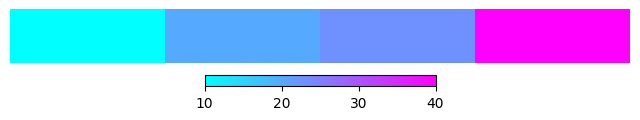

In [42]:
def values_to_colormap(values, plot=False, as_hex=False, cm=None):
    norm = auto.matplotlib.colors.Normalize(vmin=min(values), vmax=max(values))
    cmap = config.app.colormap
    if not cm is None:
        cmap = cm
    colors = cmap(norm(values))

    if plot:
        fig, ax = plt.subplots(figsize=(8, 1))
        ax.imshow([colors], extent=[0, 1, 0, 0.1], aspect="auto")
        ax.set_axis_off()  # Remove axes for a cleaner look

        # Add the colorbar
        sm = auto.matplotlib.cm.ScalarMappable(cmap=cmap, norm=norm)  # Create ScalarMappable
        sm.set_array([])  # Required for the colorbar
        fig.colorbar(sm, orientation='horizontal', ax=ax)  # Associate with the axis

        plt.show()

    if as_hex:
        colors = [auto.matplotlib.colors.to_hex(color) for color in colors]

    return colors

def values_to_sm(values):
    norm = auto.matplotlib.colors.Normalize(vmin=min(values), vmax=max(values))
    cmap = config.app.colormap
    colors = cmap(norm(values))
    sm = auto.matplotlib.cm.ScalarMappable(cmap=cmap, norm=norm)  # Create ScalarMappable
    sm.set_array([])  # Required for the colorbar
    return sm


def scope():
    data = [10.0, 20.0, 23.0, 40.0]
    colors = values_to_colormap(data, plot=True)
/scope 

## Material to colors

[43.6, 43.9, 38.7, 41.5, 42.7, 42.1, 43.9, 46.4, 38.9, 40.1, 38.9, 38.0, 37.0, 42.7, 44.5, 41.8, 45.6, 38.7, 45.5, 39.7, 42.3, 39.6, 41.1, 45.8, 45.9, 35.7, 33.9, 47.8, 45.2, 34.5, 35.4, 40.2, 38.7, 37.6, 33.8, 50.7, 40.1, 39.3, 38.4, 37.3, 38.3, 40.4, 38.4, 40.0, 39.9, 41.0, 39.8, 38.0, 40.7, 42.0, 36.5, 39.1, 43.2, 40.7, 40.8, 40.3, 39.5, 40.1, 39.8, 28.5, 29.9, 30.3, 27.5, 29.7, 33.7, 35.1, 43.3, 30.5, 34.0, 39.7, 42.5, 38.2, 27.4, 28.3, 32.2, 30.9, 39.7, 34.4, 34.9, 38.8, 38.0, 38.7, 40.4, 39.8, 39.9, 38.1, 42.0, 45.6, 41.8, 39.0, 35.9, 36.3, 31.5, 41.0, 35.7, 32.7, 37.8, 35.0, 41.5, 43.0, 39.6, 36.1, 32.4, 46.5, 32.8, 35.4, 38.3, 44.5, 39.4, 35.3, 37.8, 43.7, 51.8, 43.7, 44.3, 38.6, 36.4, 38.0, 41.5, 41.1, 44.9, 44.0, 45.4, 37.5, 34.2, 34.5, 45.1, 34.3, 38.2, 37.6, 35.9, 37.5, 42.3, 36.8, 34.6, 35.9, 46.7, 38.3, 37.8, 45.3, 45.9, 39.2, 33.4, 45.3, 48.7, 47.4, 43.7, 46.8, 36.4, 35.4, 34.8, 37.5, 37.3, 39.2, 38.9, 38.2, 35.9, 36.1, 48.6, 35.0, 38.6, 39.6, 39.0, 37.9, 39.6, 34.3, 39.

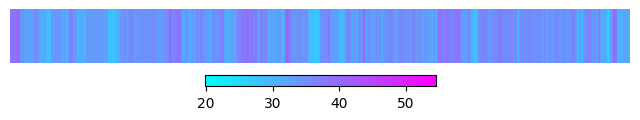

['#b04fff', '#b24dff', '#8b74ff', '#a05fff', '#a956ff', '#a45bff', '#b24dff', '#c43bff', '#8d72ff', '#9669ff', '#8d72ff', '#8679ff', '#7f80ff', '#a956ff', '#b649ff', '#a25dff', '#be41ff', '#8b74ff', '#be41ff', '#936cff', '#a659ff', '#926dff', '#9d62ff', '#c03fff', '#c13eff', '#758aff', '#6897ff', '#cf30ff', '#bb44ff', '#6c93ff', '#738cff', '#9669ff', '#8b74ff', '#837cff', '#6798ff', '#e41bff', '#9669ff', '#906fff', '#8976ff', '#817eff', '#8877ff', '#9867ff', '#8976ff', '#956aff', '#946bff', '#9c63ff', '#936cff', '#8679ff', '#9a65ff', '#a45bff', '#7b84ff', '#8e71ff', '#ad52ff', '#9a65ff', '#9b64ff', '#9768ff', '#916eff', '#9669ff', '#936cff', '#40bfff', '#4ab5ff', '#4db2ff', '#38c7ff', '#49b6ff', '#6699ff', '#718eff', '#ad52ff', '#4fb0ff', '#6996ff', '#936cff', '#a758ff', '#8877ff', '#38c7ff', '#3ec1ff', '#5ba4ff', '#52adff', '#936cff', '#6c93ff', '#6f90ff', '#8c73ff', '#8679ff', '#8b74ff', '#9867ff', '#936cff', '#946bff', '#8778ff', '#a45bff', '#be41ff', '#a25dff', '#8e71ff', '#7788ff'

In [43]:
def scope():
    # material_values = list(material_data.values())
    print(material_values)
    material_colors = values_to_colormap(material_values, plot=True, as_hex=True)
    return material_colors

material_colors = scope()
print(material_colors)

## Material Geometry

In [44]:
def scope():
    # material_geo = list(material_data.keys())
    print(material_geo[:5])
    return material_geo

material_geo = scope()

[<POLYGON ((-85.436 31.789, -85.442 31.794, -85.449 31.809, -85.457 31.821, -...>, <POLYGON ((-85.197 31.838, -85.189 31.84, -85.17 31.831, -85.153 31.829, -85...>, <POLYGON ((-85.141 31.891, -85.139 31.894, -85.14 31.902, -85.159 31.916, -8...>, <POLYGON ((-85.146 31.89, -85.146 31.893, -85.164 31.892, -85.169 31.895, -8...>, <POLYGON ((-85.146 31.89, -85.151 31.888, -85.157 31.878, -85.161 31.876, -8...>]


## Coordinate Distance

In [45]:
from geopy.distance import geodesic
def geodist(c1: (float, float), c2: (float, float)) -> float:
    # c1 = (c1[1], c1[0]) # flip to lat,lng
    # d = geodesic(c1, c2).miles
    # return d
    return auto.haversine.haversine(c1, c2, unit=auto.haversine.Unit.MILES)


# Buildings

## Config

In [46]:
config.buildings = auto.types.SimpleNamespace()

config.providers = auto.types.SimpleNamespace()
config.providers.source = auto.pathlib.Path('/mnt/seenas2/data/healthcare_providers')

config.datadir = auto.pathlib.Path('/mnt/seenas2/data/model-america/data')
assert config.datadir.exists()

# Holds csv files for all buildings. This is where we can make the geometry for them
config.buildings = config.datadir / 'MAv1_CSVS'
assert config.datadir.exists()

## Buildings from location and radius

In [47]:
from concurrent.futures import ProcessPoolExecutor
from multiprocessing import Pool, cpu_count
from functools import partial


def process_row(row, point=None, radius=None, *args, **kwargs):
    def formatted(pointstr):
        new = tuple(pointstr.split('/'))
        # new = tuple(row['Centroid'].split('/'))
        # print(new)
        final = (float(new[0]), float(new[1]))
        return final
    # print(row)
    centroid = formatted(row['Centroid'])
    # print(centroid)
    footprint = [formatted(p) for p in row['Footprint2D'].split('_')]
    points = []
    for f in footprint:
        points.append((f[1], f[0]))
    footprint = points

    if geodist((centroid[0], centroid[1]), point) < radius:
        # pbar.update()
        # buildings.append(footprint)
        return {'centroid': centroid, 'geometry': auto.shapely.Polygon(footprint)}
    return None

def parallel_process_dataframe(df, process_function=process_row, num_processes=None, *args, **kwargs):
    if num_processes is None:
        num_processes = cpu_count()
        
    # Convert DataFrame to list of rows for parallel processing
    rows = df.to_dict('records')
    
    # Create partial function with additional arguments
    process_func = partial(process_function, *args, **kwargs)
    
    # Create process pool and process rows in parallel
    with Pool(processes=num_processes) as pool:
        results = pool.map(process_func, rows)
    
    return results

def buildings_from_addr(addr: str, radius: float):
    state = addr_to_state(addr)
    print(f'Opening {state}.csv')
    df = auto.pd.read_csv(config.buildings / f'{state}.csv')

    point = addr_to_coords(addr)
    print(f'Target: {point}')

    # pbar = auto.tqdm.auto.tqdm(total=df.shape[0])
    
    buildings = parallel_process_dataframe(df, point=point, radius=radius)

    buildings = [b for b in buildings if b is not None]
    print(f'{len(buildings)} buildings')
    return buildings

def scope():
    print(config.radius)
    print(config.address)
    return buildings_from_addr(config.address, config.radius)

buildings = scope()

5
1131 West Nokomis Circle Knoxville TN
Opening TN.csv
Target: (35.9340876, -83.96616780000001)
43934 buildings


## Building Color

In [48]:
def load_providers():
    providers = auto.pandas.read_csv(config.providers.source / 'Providers.csv')

    /print type(providers)

    /auto.pprint.pp providers.columns.to_list()

    /auto.pprint.pp providers.dtypes.to_dict()

    with auto.pd.option_context('display.max_columns', None):
        /display providers

    with auto.pd.option_context('display.max_columns', None):
        /display providers.describe()
    return providers

providers_data = load_providers()

<class 'pandas.core.frame.DataFrame'>
['CMS Certification Number (CCN)',
 'Provider Name',
 'Provider Address',
 'City/Town',
 'State',
 'ZIP Code',
 'Telephone Number',
 'Provider SSA County Code',
 'County/Parish',
 'Ownership Type',
 'Number of Certified Beds',
 'Average Number of Residents per Day',
 'Average Number of Residents per Day Footnote',
 'Provider Type',
 'Provider Resides in Hospital',
 'Legal Business Name',
 'Date First Approved to Provide Medicare and Medicaid Services',
 'Affiliated Entity Name',
 'Affiliated Entity ID',
 'Continuing Care Retirement Community',
 'Special Focus Status',
 'Abuse Icon',
 'Most Recent Health Inspection More Than 2 Years Ago',
 'Provider Changed Ownership in Last 12 Months',
 'With a Resident and Family Council',
 'Automatic Sprinkler Systems in All Required Areas',
 'Overall Rating',
 'Overall Rating Footnote',
 'Health Inspection Rating',
 'Health Inspection Rating Footnote',
 'QM Rating',
 'QM Rating Footnote',
 'Long-Stay QM Rating',

CMS Certification Number (CCN)  \
0                             015009   
1                             015010   
2                             015012   
3                             015014   
4                             015015   
...                              ...   
14812                         745022   
14813                         745038   
14814                         745039   
14815                         745040   
14816                         745049   

                                           Provider Name  \
0                               BURNS NURSING HOME, INC.   
1                         COOSA VALLEY HEALTHCARE CENTER   
2                             HIGHLANDS HEALTH AND REHAB   
3            EASTVIEW REHABILITATION & HEALTHCARE CENTER   
4                          PLANTATION MANOR NURSING HOME   
...                                                  ...   
14812                          WARE MEMORIAL CARE CENTER   
14813      TIERRA ESTE NURSING AND REHABILITATION CENTER   
14814                  MIDTOWNE MEADOWS HEALTH AND REHAB   
14815                      THE SARAH ROBERTS FRENCH HOME   
14816  LAS ALTURAS NURSING & TRANSITIONAL CARE BROWNS...   

                  Provider Address     City/Town State  ZIP Code  \
0             701 MONROE STREET NW  RUSSELLVILLE    AL     35653   
1           260 WEST WALNUT STREET     SYLACAUGA    AL     35150   
2              380 WOODS COVE ROAD    SCOTTSBORO    AL     35768   
3         7755 FOURTH AVENUE SOUTH    BIRMINGHAM    AL     35206   
4      6450 OLD TUSCALOOSA HIGHWAY      MC CALLA    AL     35111   
...                            ...           ...   ...       ...   
14812        1510 S. VAN BUREN ST.      AMARILLO    TX     79101   
14813      14300 PEBBLE HILLS BLVD       EL PASO    TX     79938   
14814                110 DYLAN WAY    MIDLOTHIAN    TX     76065   
14815               1315 TEXAS AVE   SAN ANTONIO    TX     78201   
14816          180 EAST PRICE ROAD   BROWNSVILLE    TX     78521   

       Telephone Number  Provider SSA County Code County/Parish  \
0            2563324110                       290      Franklin   
1            2562495604                       600     Talladega   
2            2562183708                       350       Jackson   
3            2058330146                       360     Jefferson   
4            2054776161                       360     Jefferson   
...                 ...                       ...           ...   
14812        8063730471                       860        Potter   
14813        9159559998                       480       El Paso   
14814              1111                       470         Ellis   
14815        2107364238                       130         Bexar   
14816        9563032002                       240       Cameron   

                               Ownership Type  Number of Certified Beds  \
0                    For profit - Corporation                        57   
1                    For profit - Corporation                        85   
2                         Government - County                        50   
3                     For profit - Individual                        92   
4                     For profit - Individual                       103   
...                                       ...                       ...   
14812                For profit - Corporation                       120   
14813                For profit - Corporation                       120   
14814  For profit - Limited Liability company                       121   
14815                Non profit - Corporation                        60   
14816                For profit - Corporation                        90   

       Average Number of Residents per Day  \
0                                     50.0   
1                                     76.9   
2                                     45.1   
3                                     76.9   
4                                     86.6   
...  

ZIP Code  Telephone Number  Provider SSA County Code  \
count  14817.000000      1.481700e+04              14817.000000   
mean   50349.185733      5.887644e+09                390.753526   
std    26865.536143      2.332156e+09                272.751555   
min      660.000000      1.111000e+03                  0.000000   
25%    29732.000000      4.012532e+09                150.000000   
50%    48602.000000      6.063877e+09                360.000000   
75%    73036.000000      8.027753e+09                590.000000   
max    99929.000000      9.898959e+09                996.000000   

       Number of Certified Beds  Average Number of Residents per Day  \
count              14817.000000                         14767.000000   
mean                 106.840184                            82.972100   
std                   59.246651                            49.047237   
min                    4.000000                             1.000000   
25%                   66.000000                            50.200000   
50%                  100.000000                            75.700000   
75%                  127.000000                           104.200000   
max                  843.000000                           734.100000   

       Average Number of Residents per Day Footnote  Affiliated Entity ID  \
count                                          50.0           9885.000000   
mean                                           10.0            329.863429   
std                                             0.0            194.409733   
min                                            10.0              1.000000   
25%                                            10.0            158.000000   
50%                                            10.0            316.000000   
75%                                            10.0            502.000000   
max                                            10.0            694.000000   

       Overall Rating  Overall Rating Footnote  Health Inspection Rating  \
count    14673.000000               144.000000              14673.000000   
mean         2.863218                11.270833                  2.784298   
std          1.432041                 8.342510                  1.273479   
min          1.000000                 1.000000                  1.000000   
25%          2.000000                 1.000000                  2.000000   
50%          3.000000                18.000000                  3.000000   
75%          4.000000                18.000000                  4.000000   
max          5.000000                18.000000                  5.000000   

       Health Inspection Rating Footnote     QM Rating  QM Rating Footnote  \
count                         144.000000  14563.000000          350.000000   
mean                           11.270833      3.502575           13.528571   
std                             8.342510      1.278182            8.363383   
min                             1.000000      1.000000            1.000000   
25%                             1.000000      3.000000            2.000000   
50%                            18.000000      4.000000           18.000000   
75%                            18.000000      5.000000           20.000000   
max                            18.000000      5.000000           20.000000   

       Long-Stay QM Rating  Long-Stay QM Rating Footnote  \
count         14230.000000                    683.000000   
mean              3.473436                      7.907760   
std               1.390142                      8.309553   
min               1.000000                      1.000000   
25%               2.000000                      2.000000   
50%               4.000000                      2.000000   
75%               5.000000                     18.000000   
max               5.000000                     20.000000   

       Short-Stay QM Rating  Short-Stay QM Rating Footnote  Staffing Rating  \
count          12146.000000                    2671.0000

In [49]:
def building_color(building_centroids: [(float, float)], dataset: auto.pd.DataFrame, attribute: str, K: int):
    print(building_centroids)
    data = dataset.dropna(subset=attribute)
    # data_values = auto.np.array(data[attribute])

    colormap = auto.matplotlib.pyplot.get_cmap('Oranges')
    building_values = []
    for centroid in auto.tqdm.auto.tqdm(building_centroids):
        dists = []
        for row in data.iterrows():
            # print(row[1]['Location'])
            dists.append({
                'distance': geodist((centroid[0], centroid[1]), (row[1]['Location'][0], row[1]['Location'][1])),
                'value': row[1][attribute],
            })
        dists = sorted(dists, key=lambda dists: dists['distance'])[:K]
        values = [dist['value'] for dist in dists]
        value = auto.np.average(values)
        building_values.append(value)
    
    colors = values_to_colormap(building_values, as_hex=True, cm=colormap)
    print(colors)
    return colors

def scope():
    in_state_providers = providers_data[providers_data['State'] == f'{addr_to_state(config.address)}']
    # /display in_state_providers
    provider_ratings = in_state_providers['Overall Rating']
    provider_locations = list(zip(in_state_providers['Latitude'], in_state_providers['Longitude']))
    # /display provider_locations
    target_provider_values = {
        'Location': provider_locations,
        'Overall Rating': provider_ratings,
    }
    df = auto.pd.DataFrame(target_provider_values)
    # /display df
    centroids = [b['centroid'] for b in buildings]
    return building_color(centroids, df, attribute='Overall Rating', K=5)

building_colors = scope()

[(35.873236171882695, -84.0126835124833), (35.866898613372946, -83.99134880427793), (35.864752, -83.96032299999999), (35.865697275714105, -83.9665826531206), (35.87417051677899, -83.9864178438528), (35.867540230173425, -83.98155747520524), (35.871859685176034, -83.94574304605624), (35.8642609907546, -83.96075017246339), (35.862154017632676, -83.96497907889487), (35.865140999999994, -83.95134300000001), (35.87700666666667, -84.00040466666667), (35.8696200111462, -83.99224783426216), (35.86666013660974, -83.99003645330272), (35.8720385, -83.95342550000001), (35.86458561107282, -83.96380067057203), (35.86382759643536, -83.94790483875063), (35.86265922542933, -83.97841680674593), (35.8633645, -83.961945), (35.865397, -83.95867550000001), (35.8654435, -83.95063099999999), (35.87172152237683, -83.98496152576963), (35.865686597295706, -83.98427370499707), (35.87040001118922, -83.98358179789871), (35.8650390067649, -83.97946013719604), (35.86641066027389, -83.96593653065625), (35.8665264082236

  0%|          | 0/43934 [00:00<?, ?it/s]

['#fdd5ad', '#fdd5ad', '#fdb97d', '#fdb97d', '#fdd5ad', '#fdd5ad', '#f87d29', '#fdb97d', '#fdb97d', '#fdb97d', '#fdd5ad', '#fdd5ad', '#fdd5ad', '#fdb97d', '#fdb97d', '#fdb97d', '#fdd5ad', '#fdb97d', '#fdb97d', '#fdb97d', '#fdd5ad', '#fdd5ad', '#fdd5ad', '#fdd5ad', '#fdb97d', '#fdb97d', '#fdb97d', '#fdd5ad', '#fdd5ad', '#fdb97d', '#fdb97d', '#fdb97d', '#fdb97d', '#fdb97d', '#fdb97d', '#f87d29', '#fdd5ad', '#fdb97d', '#fdd5ad', '#fdb97d', '#fdb97d', '#fdd5ad', '#fdd5ad', '#fdd5ad', '#fdb97d', '#fff5eb', '#fdb97d', '#fdb97d', '#fdb97d', '#fdb97d', '#fdd5ad', '#fdd5ad', '#fdb97d', '#fdd5ad', '#fdd5ad', '#fff5eb', '#fdb97d', '#fdb97d', '#fdd5ad', '#fdd5ad', '#fdb97d', '#fdb97d', '#fdb97d', '#fdd5ad', '#fdb97d', '#fdb97d', '#fdd5ad', '#fdb97d', '#fdb97d', '#fdb97d', '#fdd5ad', '#fdd5ad', '#fdb97d', '#fdb97d', '#fdd5ad', '#fdd5ad', '#fdb97d', '#fdb97d', '#fdb97d', '#f87d29', '#f87d29', '#fdd5ad', '#fdd5ad', '#fdd5ad', '#fdd5ad', '#fdb97d', '#f87d29', '#fdb97d', '#f87d29', '#fdd5ad', '#fdb97d'

## Visualize Buildings

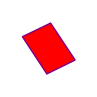

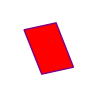

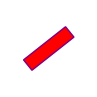

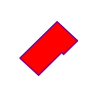

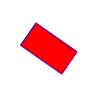

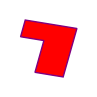

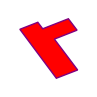

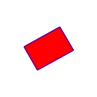

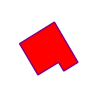

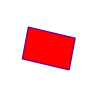

In [50]:
def look(building):
    centroid = building['centroid']
    geo = list(building['geometry'].exterior.coords)

    min_x = min([p[0] for p in geo])
    min_y = min([p[1] for p in geo])
    max_x = max([p[0] for p in geo])
    max_y = max([p[1] for p in geo])
    poly = auto.matplotlib.patches.Polygon(
        geo,
        facecolor='red',
        edgecolor='purple',
    )
    fig, ax = plt.subplots(1,1, figsize=(1,1))

    ax.add_patch(poly)
    auto.plt.ylim(min_y-0.00005, max_y+0.00005)
    auto.plt.xlim(min_x-0.00005, max_x+0.00005)
    auto.plt.axis('off')
    auto.plt.show()

def scope():
    for i in range(10):
        look(buildings[i])

/scope

## App

In [51]:
def scope():
    # /display material_data
    center_lat, center_lon = addr_to_coords(config.address)
    print(center_lat, center_lon)
    geo = GeoTileCalculator(center_lat, center_lon)

    tiles = geo.get_covering_tiles(radius_miles=config.radius)

    tile_data = {}
    for tile in auto.tqdm.auto.tqdm(tiles):
        # print(f'Tile ({tile[0]}, {tile[1]}, {tile[2]})')
        img = Satellite.from_http(row=tile[0], col=tile[1], zoom=tile[2])
        tile_data[(tile[0], tile[1], tile[2])] = img
        # /display img

    bounds = geo.get_bounding_box(radius_miles=config.radius)

    material_colors = values_to_colormap(material_values)
    assert len(material_geo) == len(material_values)
    assert len(material_geo) == len(material_colors)
    geometry = []
    min_material_values = []
    min_material_polys = []
    for i in auto.tqdm.auto.tqdm(range(len(material_geo))):
        min_dist = 100000.0
        poly_coords = list(material_geo[i].exterior.coords)
        for coord in poly_coords:
            coord = (coord[1], coord[0])
            # print(geodist(poly_coords[0], (center_lon, center_lat)), end='\r')
            min_dist = min(min_dist, geodist(coord, (center_lat, center_lon)))
        # print(min_dist)
        
        # if geodist(poly_coords[0], (center_lat, center_lon)) < (config.radius):
        if min_dist < (config.radius * 1.2) or is_point_in_polygon((center_lon, center_lat), poly_coords):
            # print(min_dist, end='\r')
            min_material_values.append(material_values[i])
            min_material_polys.append(poly_coords)
            # geometry.append(
            #     {
            #         'coordinates': poly_coords,
            #         'color': material_colors[i],
            #         'border': 'black',
            #         'alpha': 0.6,
            #         'label': ''
            #     },
            # )
    min_material_colors = values_to_colormap(min_material_values, as_hex=True)
    for i in range(len(min_material_polys)):
        geometry.append(
            {
                'coordinates': min_material_polys[i],
                'color': min_material_colors[i],
                'border': 'black',
                'alpha': 0.3,
                'label': f'{min_material_values[i]}'
            },
        )

    
    # Geo for tbe buildings
    buildings_to_render = None
    if config.radius >= 100.0:
        buildings_to_render = []
    elif config.radius >= 2.0:
        print(f'Buildings: {len(buildings)}')
        # percent = (360.53 / config.radius) - 2.1053
        segment_size = int(len(buildings) / 20)
        percent = 70
        print(f'Percent: {percent}')
        # percent = 40

        n = int(len(buildings) * (percent / 100))
        buildings_to_render = auto.random.sample(buildings, n)
        
        print(f'Remaining number of buildings: {len(buildings_to_render)}')
    else:
        buildings_to_render = buildings

    for i in auto.tqdm.auto.tqdm(range(len(buildings_to_render))):
        poly_coords = list(buildings_to_render[i]['geometry'].exterior.coords)
        geometry.append(
            {
                'coordinates': poly_coords,
                'color': f'{building_colors[i]}',
                'border': f'{building_colors[i]}',
                'alpha': 0.7,
                'label': ''
            },
        )

    print(f'Number of polygons: {len(geometry)}')
    geo.plot_tiles(
        radius_miles=config.radius, 
        tile_images=tile_data, 
        show_tile_bounds=False, 
        polygons=geometry,
        save='test.png',
        colors=values_to_sm(material_values),
        color_values=material_values,
    )

# /scope

# Leaflet

In [52]:
from ipyleaflet import Map, TileLayer, basemaps, basemap_to_tiles, Polygon
from ipyleaflet import LayersControl

class Map:
    center: (float, float) = None
    L = None
    tile_layers = {
        'nasa': basemap_to_tiles(basemaps.NASAGIBS.ModisTerraTrueColorCR, "2018-04-08"),
    }

    mapbox_styles = {
        'satellite': 'https://api.mapbox.com/styles/v1/mapbox/satellite-streets-v12/tiles/{{z}}/{{x}}/{{y}}?access_token={access_token}',
        'dark': 'https://api.mapbox.com/styles/v1/mapbox/dark-v11/tiles/{{z}}/{{x}}/{{y}}?access_token={access_token}',
        'night': 'https://api.mapbox.com/styles/v1/mapbox/navigation-night-v1/tiles/{{z}}/{{x}}/{{y}}?access_token={access_token}',
    }
    
    def __init__(self, center=None, zoom=None):
        self.center = center
        self.L = auto.ipyleaflet.Map(center=self.center, zoom=zoom)
        # self.L.add(self.tile_layers['nasa'])

    def use_mapbox(self, name, api_key):
        tiles = TileLayer(
            url=self.mapbox_styles[name].format(access_token=api_key),
            attribution='Mapbox'
        )
        self.L.add_layer(tiles)
        return self
    
    def add_polygon(self, polygon):
        self.L.add_layer(polygon)

    def display(self):
        /display self.L

In [54]:
def scope():
    center_lat, center_lon = addr_to_coords(config.address)
    lmap = Map(center=(center_lat, center_lon), zoom=15)
    lmap.use_mapbox('dark', config.mapbox.token)

    material_colors = values_to_colormap(material_values)
    assert len(material_geo) == len(material_values)
    assert len(material_geo) == len(material_colors)
    geometry = []
    min_material_values = []
    min_material_polys = []
    for i in auto.tqdm.auto.tqdm(range(len(material_geo))):
        min_dist = 100000.0
        poly_coords = list(material_geo[i].exterior.coords)
        for coord in poly_coords:
            coord = (coord[1], coord[0])
            # print(geodist(poly_coords[0], (center_lon, center_lat)), end='\r')
            min_dist = min(min_dist, geodist(coord, (center_lat, center_lon)))
        
        if min_dist < (config.radius * 1.2) or is_point_in_polygon((center_lon, center_lat), poly_coords):
            min_material_values.append(material_values[i])
            min_material_polys.append(poly_coords)
         
    min_material_colors = values_to_colormap(min_material_values, as_hex=True)
    new_geo = []
    for g in min_material_polys:
        newlist = []
        for p in g:
            newlist.append((p[1], p[0]))
        new_geo.append(newlist)
    for i in auto.tqdm.auto.tqdm(range(len(new_geo))):
        lmap.add_polygon(auto.ipyleaflet.Polygon(
            locations=new_geo[i],
            # locations=min_material_polys[i],
            color=min_material_colors[i],
            weight=1,
            fill_color=min_material_colors[i],
            fill_opacity=0.15
        ))

    buildings_to_render = None
    if config.radius >= 100.0:
        buildings_to_render = []
    elif config.radius >= 2.0:
        print(f'Buildings: {len(buildings)}')
        segment_size = int(len(buildings) / 20)
        percent = 30
        print(f'Percent: {percent}')

        n = int(len(buildings) * (percent / 100))
        buildings_to_render = auto.random.sample(buildings, n)
        
        print(f'Remaining number of buildings: {len(buildings_to_render)}')
    else:
        buildings_to_render = buildings

    for i in auto.tqdm.auto.tqdm(range(len(buildings_to_render))):
        poly_coords = list(buildings_to_render[i]['geometry'].exterior.coords)
        coords = []
        for coord in poly_coords:
            coords.append((coord[1], coord[0]))
        lmap.add_polygon(auto.ipyleaflet.Polygon(
            locations=coords,
            # locations=min_material_polys[i],
            color=building_colors[i],
            weight=1,
            # color=None,
            fill_color=building_colors[i],
            fill_opacity=0.8
        ))
        # geometry.append(
        #     {
        #         'coordinates': poly_coords,
        #         'color': f'{building_colors[i]}',
        #         'border': f'{building_colors[i]}',
        #         'alpha': 0.7,
        #         'label': ''
        #     },
        # )

    # print(f'Number of polygons: {len(geometry)}')
    # geo.plot_tiles(
    #     radius_miles=config.radius, 
    #     tile_images=tile_data, 
    #     show_tile_bounds=False, 
    #     polygons=geometry,
    #     save='test.png',
    #     colors=values_to_sm(material_values),
    #     color_values=material_values,
    # )
       
    lmap.display()
/scope

  0%|          | 0/72723 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

Buildings: 43934
Percent: 30
Remaining number of buildings: 13180


  0%|          | 0/13180 [00:00<?, ?it/s]

Map(center=[35.9340876, -83.96616780000001], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_…